# Dynamic Baysian Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import defaultdict
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind
from itertools import combinations
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.multitest import multipletests

In [4]:
from matplotlib import font_manager
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rcParams.update({
    'font.size': 8,
    'axes.titlesize': 8,
    'legend.fontsize': 8,
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'axes.linewidth': 0.5,
    'xtick.major.width': 0.5,
    'xtick.major.size': 2,
    'xtick.minor.size': 2,
    'xtick.minor.width': 0.5,
    'ytick.major.width': 0.5,
    'ytick.minor.width': 0.5,
    'ytick.major.size': 2,
    'ytick.minor.size': 2,
})

In [5]:
np.random.seed(42)

# Parameter Definition

In [6]:
env = 4 # 4:Lever push-pull
level = 1 # 0:Easy, 1:Middle, 2:Hard
no = 3
num_repeats = 1000
opto = "" # "L2IT" or "L5IT"

# Markov chain

In [7]:
class Markov:
    """Class for a Markov chain"""

    def __init__(self, ptr):
        """Create a new environment"""
        self.ptr = ptr  # transition matrix p(x'|x)
        self.Ns = len(ptr)  # number of states

    def sample(self, x0=0, step=1):
        """generate a sample sequence from x0"""
        seq = np.zeros(step+1, dtype=int) # sequence buffer
        seq[0] = x0
        for t in range(step):
            pt1 = self.ptr[:, seq[t]] # prob. of new states
            seq[t+1] = np.random.choice(self.Ns, p=pt1) # sample
        return seq

    def forward(self, p0, step=1):
        """forward message from initial distribution p0"""
        alpha = np.zeros((step+1, self.Ns)) # priors
        alpha[0] = p0  # initial distribution
        for t in range(step):
            alpha[t+1] = self.ptr @ alpha[t]
        return alpha

    def backward(self, obs, step=1):
        """backward message from terminal observaion"""
        beta = np.zeros((step+1, self.Ns)) # likelihoods
        beta[-1] = obs  # observation
        for t in range(step, 0, -1): # toward 0
            beta[t-1] = beta[t] @ self.ptr
        return beta

    def posterior(self, p0, obs, step):
        """forward-backward algorithm"""
        alpha = self.forward(p0, step)
        beta = self.backward(obs, step)
        post = alpha*beta
        for t in range(step+1):
            post[t] = post[t]/sum(post[t])  # normalize
        return post

## Dynamic Bayesian Inference


### Hidden Markov model


In [8]:
class HMM(Markov):
    """Hidden Markov model"""

    def __init__(self, ptr, pobs):
        """Create HMM with transition and observation models"""
        super().__init__(ptr)
        self.pobs = pobs  # observation model
        self.No = len(pobs)  # number of observations
        self.pst = np.ones(self.Ns)/self.Ns  # state distribution
        self.pred = np.zeros(self.Ns)  # predictive distribution

    def sample(self, x0=0, step=10):
        """generate a sample sequence from x0"""
        xt = np.zeros(step, dtype=int) # state sequence
        yt = np.zeros(step, dtype=int) # observation sequence
        xt[0] = x0
        po = self.pobs[:, x0] # prob. of observation
        yt[0] = np.random.choice(self.No, p=po) # observe
        for t in range(1, step):
            ps = self.ptr[:, xt[t-1]]  # prob. of new states
            xt[t] = np.random.choice(self.Ns, p=ps) # transit
            po = self.pobs[:, xt[t]]   # prob. of observation
            yt[t] = np.random.choice(self.No, p=po) # observe
        return xt, yt

    def predict(self):
        """predictive prior by transition model"""
        self.pred = self.ptr @ self.pst # L5IT = L3IT @ L5PT

    def update(self, obs):
        """update posterior by observation"""
        prl = self.pobs[obs]*self.pred # likelihood*prior # L2IT*L5IT
        self.pst = prl/sum(prl)  #normalize # L5PT <- L5SST

    def reset(self):
        """reset state probability"""
        self.pst = np.ones(self.Ns)/self.Ns  # uniform

    def step(self, obs):
        """one step of dynamic bayesian inference"""
        self.predict()
        self.update(obs)
        max_index = np.random.choice(np.where(self.pst == np.max(self.pst))[0]) # L6IT <- L6SST
        map_estimate = np.zeros_like(self.pst)
        map_estimate[max_index] = 1
        obs_one_hot = np.zeros(self.No)
        obs_one_hot[obs] = 1
        nll = np.where(self.pobs[obs] != 0, -np.log(self.pobs[obs]), 0)
        return self.pst, obs_one_hot, self.pobs[obs], self.ptr, self.pred, map_estimate, nll

    def update_L2(self, obs):
        """update posterior by observation"""
        prl = self.pred # L2IT*L5IT
        self.pst = prl/sum(prl)  #normalize # L5PT <- L5SST

    def step_L2(self, obs):
        """one step of dynamic bayesian inference"""
        self.predict()
        self.update_L2(obs)
        max_index = np.random.choice(np.where(self.pst == np.max(self.pst))[0]) # L6IT <- L6SST
        map_estimate = np.zeros_like(self.pst)
        map_estimate[max_index] = 1
        obs_one_hot = np.zeros(self.No)
        obs_one_hot[obs] = 1
        nll = np.where(self.pobs[obs] != 0, -np.log(self.pobs[obs]), 0)
        return self.pst, obs_one_hot, self.pobs[obs], self.ptr, self.pred, map_estimate, nll

    def update_L5(self, obs):
        """update posterior by observation"""
        prl = self.pobs[obs] # L2IT*L5IT
        self.pst = prl/sum(prl)  # L5PT <- L5SST

    def step_L5(self, obs):
        """one step of dynamic bayesian inference"""
        self.predict()
        self.update_L5(obs)
        max_index = np.random.choice(np.where(self.pst == np.max(self.pst))[0]) # L6IT <- L6SST
        map_estimate = np.zeros_like(self.pst)
        map_estimate[max_index] = 1
        obs_one_hot = np.zeros(self.No)
        obs_one_hot[obs] = 1
        nll = np.where(self.pobs[obs] != 0, -np.log(self.pobs[obs]), 0)
        return self.pst, obs_one_hot, self.pobs[obs], self.ptr, self.pred, map_estimate, nll

    def simulate_observations(self, time_steps=100, time_bin=9.0, peristimulus=700.0):
        ns = self.ptr.shape[0]
        no = self.pobs.shape[0]

        current_state = np.random.choice(ns)

        xt = np.zeros(time_steps, dtype=int)
        yt = np.zeros(time_steps, dtype=int)
        xt[0] = current_state

        for t in range(time_steps):
            yt[t] = np.random.choice(no, p=self.pobs[:, current_state])

            if t < time_steps - 1:
                current_state = np.random.choice(ns, p=self.ptr[:, current_state])
                xt[t + 1] = current_state

        start_times = []
        durations = []
        current_duration = 0
        in_observation_0 = False

        for t in range(time_steps):
            if yt[t] == 0:
                if not in_observation_0:
                    start_times.append(t)
                    in_observation_0 = True
                current_duration += 1
            else:
                if in_observation_0:
                    durations.append(current_duration)
                    current_duration = 0
                    in_observation_0 = False

        if in_observation_0:
            durations.append(current_duration)

        start_times = (np.array(start_times) * time_bin + peristimulus).tolist()
        durations = (np.array(durations) * time_bin).tolist()

        return start_times, durations, xt, yt

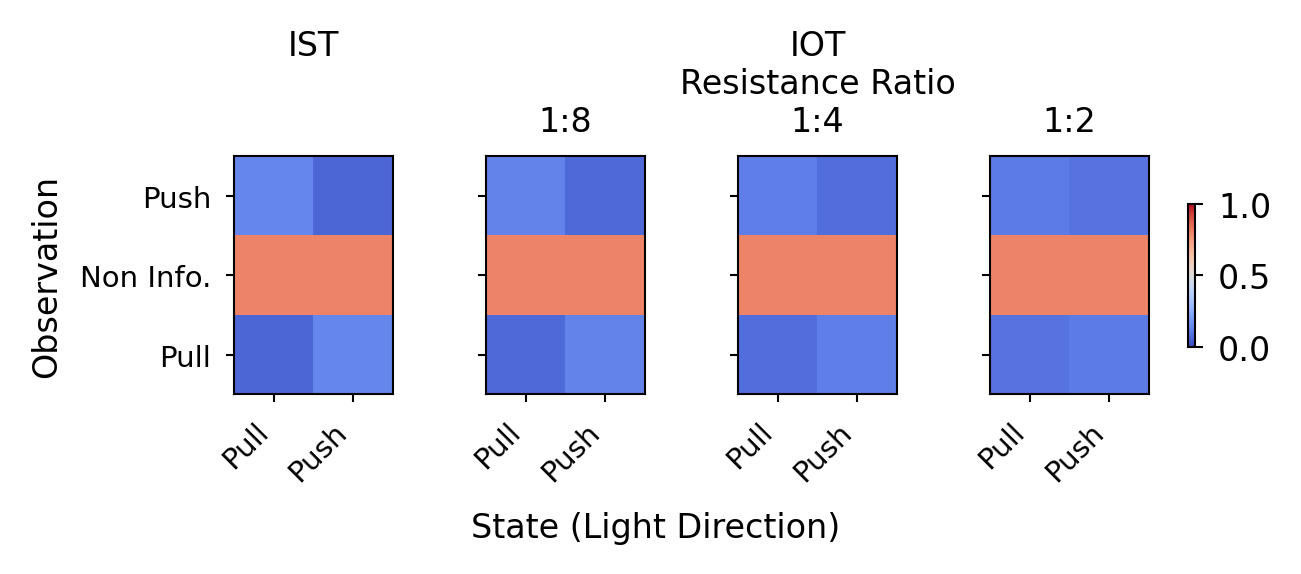

In [9]:
ns = 2
no = 3
pobs_levels = []
difficulty_params = [0.14, 0.13, 0.12, 0.11] # not IOT, Easy, Middle, Hard
for po in difficulty_params:
    Pobs_level = np.zeros((no, ns))
    Pobs_level[0, 0] = Pobs_level[2, 1] = po
    Pobs_level[2, 0] = Pobs_level[0, 1] = 0.2 - po
    Pobs_level[1, 0] = Pobs_level[1, 1] = 0.8
    pobs_levels.append(Pobs_level)
input_size = no

fig, axes = plt.subplots(1, 4,
                        figsize=(4.2, 1.8),
                        dpi=300,
                        sharey=True,
                        gridspec_kw={'wspace': -0.1},
                        constrained_layout=True)

titles = ['IST\n\n', '1:8', 'IOT\nResistance Ratio\n1:4', '1:2']

for i, ax in enumerate(axes):
    Pobs = pobs_levels[i]
    im = ax.imshow(Pobs, cmap='coolwarm', vmin=0, vmax=1)

    ax.set_title(titles[i], fontsize=8)
    ax.set_xticks(ticks=[0, 1], labels=['Pull', 'Push'], rotation=45, ha='right', fontsize=7)

axes[0].set_ylabel("Observation", fontsize=8)
axes[0].set_yticks(ticks=[0, 1, 2], labels=["Push","Non Info.","Pull"], fontsize=7)

fig.supxlabel("State (Light Direction)", fontsize=8)

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, pad=0.04)

plt.savefig("observation_model_env4_levels.svg", format="svg", bbox_inches='tight')
plt.show()
plt.close()


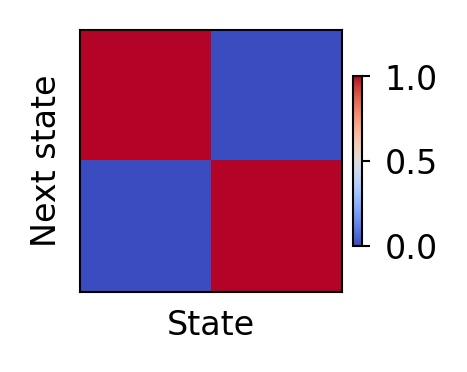

In [10]:
def plot_transition_matrix(Ptr, filename):
    plt.figure(figsize=(1.6, 1.6), dpi=300)
    im = plt.imshow(Ptr, cmap='coolwarm', vmin=0, vmax=1)
    plt.xlabel("State")
    plt.ylabel("Next state")
    plt.colorbar(im, fraction=0.03, pad=0.04, shrink=0.8)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.savefig(filename, format='svg', bbox_inches='tight')
    plt.show()
    plt.close()

# random walk on a ring
ns = 2
ps = 0

Ptr = np.zeros((ns, ns))
for i in range(ns):
    Ptr[i, i] = 1 - ps
    Ptr[(i + 1) % ns, i] = ps

# Plot and save as SVG
plot_transition_matrix(Ptr, filename=f"state_transition_env{env}.svg")

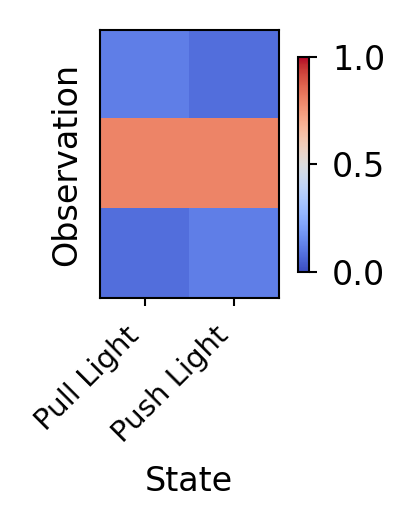

In [11]:
# Blurred intermittent observation model
ns = 2
no = 3
if level == 0:
    po = 0.13
elif level == 1:
    po = 0.12
elif level == 2:
    po = 0.11
Pobs = np.zeros((no, ns))
Pobs[0, 0] = Pobs[2, 1] = po
Pobs[2, 0] = Pobs[0, 1] = 0.2 - po
Pobs[1, 0] = Pobs[1, 1] = 0.8
input_size = no

# Plot and save as SVG with 'coolwarm' colormap

plt.figure(figsize=(2.2, 1.8), dpi=300)
im = plt.imshow(Pobs, cmap='coolwarm', vmin=0, vmax=1)
plt.colorbar(im, fraction=0.03, pad=0.04, shrink=0.8)
plt.xlabel("State")
plt.ylabel("Observation")
plt.xticks(ticks=[0, 1], labels=['Pull Light', 'Push Light'], rotation=45, ha='right', fontsize=7)
plt.yticks([])
plt.tight_layout()
plt.savefig(f"observation_model_env{env}.svg", format="svg", bbox_inches='tight')
plt.show()
plt.close()

In [12]:
# crate a HMM
ring = HMM(Ptr, Pobs)

In [13]:
# sample a state trajectory and observations
T = 100

In [14]:
# Simulate
start_times, durations, xt, yt = ring.simulate_observations(T)

In [15]:
# Dynamic Bayesian inference in HMM
post = np.zeros((T, ns))  # posterior trajectory
observation = np.zeros((T, no))
likelihood = np.zeros((T, ns))
prediction =  np.zeros((ns, ns))
predictiveprior = np.zeros((T, ns))
mapestimate = np.zeros((T, ns))
nll = np.zeros((T, ns))

ring.reset()
if opto == "L2IT":
    for t in range(T):
        if t < T//2:
            post[t], observation[t], likelihood[t], prediction, predictiveprior[t], mapestimate[t], nll[t]  = ring.step(yt[t])
        else:
            post[t], observation[t], likelihood[t], prediction, predictiveprior[t], mapestimate[t], nll[t]  = ring.step_L2(yt[t])
    L2_likelihood = np.zeros(np.shape(likelihood))
    L2_likelihood[:len(likelihood)//2] = nll[:len(likelihood)//2]
    prediction_array = predictiveprior
elif opto == "L5IT":
    for t in range(T):
        if t < T//2:
            post[t], observation[t], likelihood[t], prediction, predictiveprior[t], mapestimate[t], nll[t]  = ring.step(yt[t])
        else:
            post[t], observation[t], likelihood[t], prediction, predictiveprior[t], mapestimate[t], nll[t]  = ring.step_L5(yt[t])
    L2_likelihood = nll
    prediction_array = predictiveprior.copy()
    predictiveprior[T//2:] = 0
else:
    for t in range(T):
        post[t], observation[t], likelihood[t], prediction, predictiveprior[t], mapestimate[t], nll[t]  = ring.step(yt[t])
    L2_likelihood = nll
    prediction_array = predictiveprior

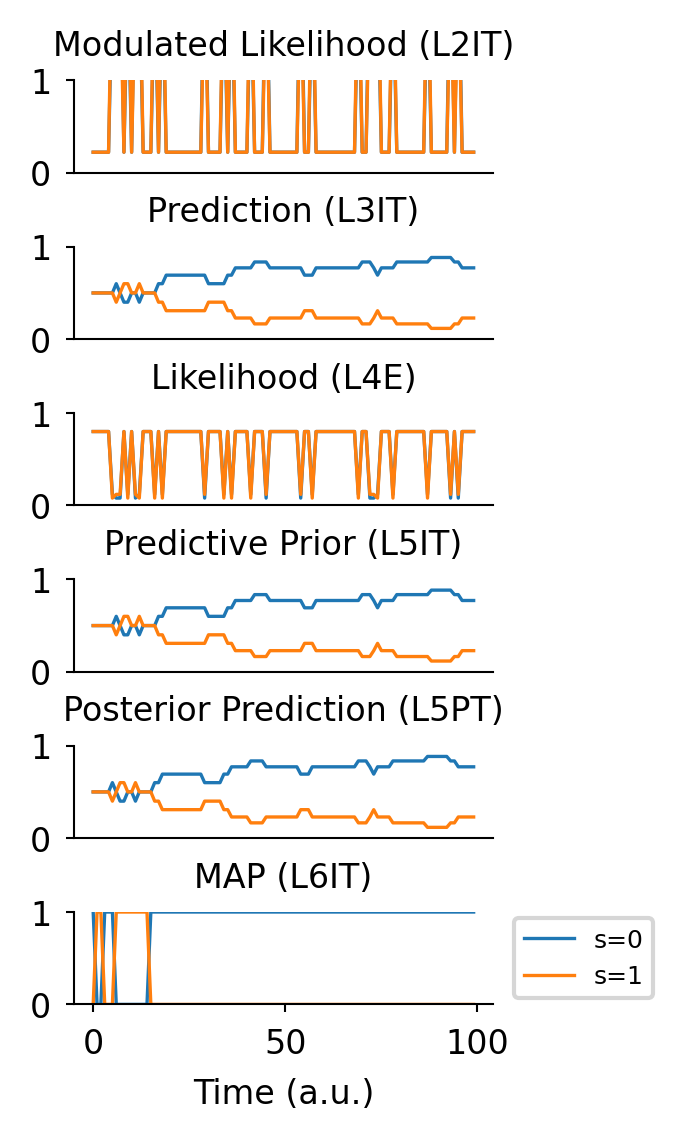

In [16]:
# Create figure to match previous panel size
fig, ax = plt.subplots(6, 1, figsize=(1.8, 4.0), dpi=300)

# Font and line settings to match previous plot
title_fontsize = 8
label_fontsize = 8
tick_fontsize = 8
line_width = 0.8

labels = [f's={i}' for i in range(ns)]
T = L2_likelihood.shape[0]
t_half = T // 2 if opto in ("L2IT", "L5IT") else None

panel_data = [
    (L2_likelihood, 'Modulated Likelihood (L2IT)'),
    (prediction_array, 'Prediction (L3IT)'),
    (likelihood, 'Likelihood (L4E)'),
    (predictiveprior, 'Predictive Prior (L5IT)'),
    (post, 'Posterior Prediction (L5PT)'),
    (mapestimate, 'MAP (L6IT)'),
]

for i, (data, title) in enumerate(panel_data):
    for s in range(ns):
        ax[i].plot(data[:, s], label=labels[s], linewidth=line_width)
    ax[i].set_title(title, fontsize=title_fontsize)
    ax[i].tick_params(labelsize=tick_fontsize)
    ax[i].set_ylim(0, 1)

    # Remove right and top spines
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

    # Remove x-tick labels except last plot
    if i < len(ax) - 1:
        ax[i].tick_params(labelbottom=False, bottom=False)
    else:
        ax[i].set_xlabel('Time (a.u.)', fontsize=label_fontsize)

    if t_half is not None:
        ax[i].axvline(x=t_half, color='black', linestyle='--', linewidth=0.8)

# Legend only in the last panel, outside
ax[-1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=6)

# Adjust vertical spacing
plt.subplots_adjust(hspace=0.8)
plt.savefig("bayesian_estimation_panels.svg", format="svg", bbox_inches='tight')
plt.show()
plt.close()



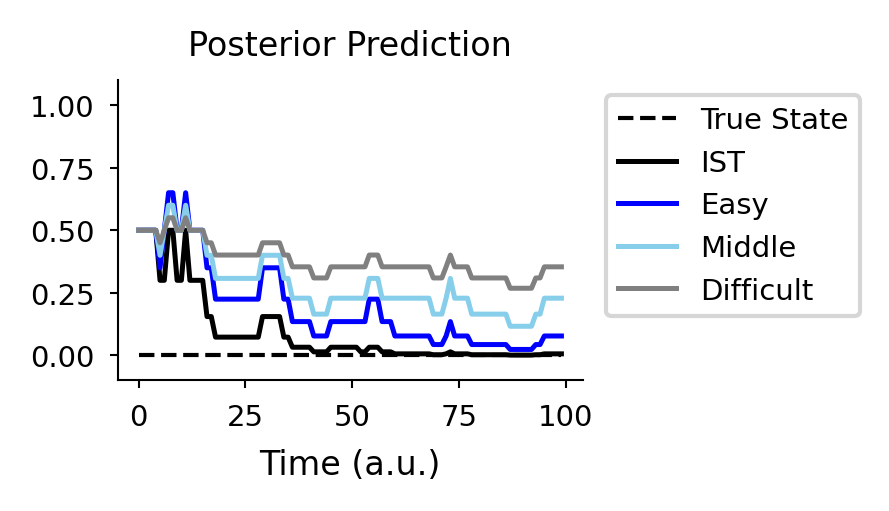

In [17]:

levels = [-1, 0, 1, 2]
colors = ['#000000','#0000FF', '#87CEEB', '#808080']  # Blue, SkyBlue, Gray
labels = ['IST','Easy', 'Middle', 'Difficult']
posteriors_s1 = []
xt_actual = None

for i, level in enumerate(levels):
    np.random.seed(42)

    if level == 0:
        po = 0.13
    elif level == 1:
        po = 0.12
    elif level == 2:
        po = 0.11
    else:
        po = 0.14


    Pobs = np.zeros((no, ns))
    Pobs[0, 0] = Pobs[2, 1] = po
    Pobs[2, 0] = Pobs[0, 1] = 0.2 - po
    Pobs[1, 0] = Pobs[1, 1] = 0.8

    ring = HMM(Ptr, Pobs)
    _, _, xt, yt = ring.simulate_observations(T)

    if xt_actual is None:
        xt_actual = xt

    post_trajectory = np.zeros((T, ns))

    for t in range(T):
        post_trajectory[t], _, _, _, _, _, _ = ring.step(yt[t])

    posteriors_s1.append(post_trajectory[:, 1])

fig, ax = plt.subplots(figsize=(2.0, 1.3), dpi=300)

title_fontsize = 8
label_fontsize = 8
tick_fontsize = 7
legend_fontsize = 7

ax.set_title('Posterior Prediction', fontsize=title_fontsize)
ax.set_xlabel('Time (a.u.)', fontsize=label_fontsize)

true_state_s1 = (xt_actual == 1).astype(int)
ax.plot(true_state_s1, color='black', linestyle='--', linewidth=1.0, label='True State', drawstyle='steps-post')

for i in range(len(levels)):
    ax.plot(posteriors_s1[i], color=colors[i], linewidth=1.2, label=labels[i])

ax.set_ylim(-0.1, 1.1)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=legend_fontsize)

plt.savefig("hmm_posterior_styled.svg", format="svg", bbox_inches='tight')
plt.show()

# DBI simulations for quantification

In [18]:
results_list = []
levels = [0, 1, 2]

for level in levels:
    if level == 0:
        po = 0.13
    elif level == 1:
        po = 0.12
    elif level == 2:
        po = 0.11
    Pobs = np.zeros((no, ns))
    Pobs[0, 0] = Pobs[2, 1] = po
    Pobs[2, 0] = Pobs[0, 1] = 0.2 - po
    Pobs[1, 0] = Pobs[1, 1] = 0.8
    ring = HMM(Ptr, Pobs)
    for iteration in range(num_repeats):
        # Simulate observation sequence and underlying states
        start_times, durations, xt, yt = ring.simulate_observations(T)

        # Initialize inference variables
        post = np.zeros((T, ns))
        observation = np.zeros((T, no))
        likelihood = np.zeros((T, ns))
        nll = np.zeros((T, ns))
        prediction = np.zeros((ns, ns))
        predictiveprior = np.zeros((T, ns))
        mapestimate = np.zeros((T, ns))

        # Reset model state
        ring.reset()

        # Perform dynamic Bayesian inference
        if opto == "L2IT":
            for t in range(T):
                if t < T//2:
                    post[t], observation[t], likelihood[t], prediction, predictiveprior[t], mapestimate[t], nll[t]  = ring.step(yt[t])
                else:
                    post[t], observation[t], likelihood[t], prediction, predictiveprior[t], mapestimate[t], nll[t]  = ring.step_L2(yt[t])
        elif opto == "L5IT":
            for t in range(T):
                if t < T//2:
                    post[t], observation[t], likelihood[t], prediction, predictiveprior[t], mapestimate[t], nll[t]  = ring.step(yt[t])
                else:
                    post[t], observation[t], likelihood[t], prediction, predictiveprior[t], mapestimate[t], nll[t]  = ring.step_L5(yt[t])
        else:
            for t in range(T):
                post[t], observation[t], likelihood[t], prediction, predictiveprior[t], mapestimate[t], nll[t]  = ring.step(yt[t])

        current_result = {
            'level': level,
            'iteration': iteration,
            'xt': xt,
            'yt': yt,
            'likelihood': likelihood,
            'nll': nll,
            'prediction_array': predictiveprior,
            'predictiveprior': predictiveprior,
            'post': post,
            'mapestimate': mapestimate,
            'start_times': start_times,
            'durations': durations
        }
        results_list.append(current_result)

results_df = pd.DataFrame(results_list)



--- Success rate by difficulty (Push/Pull, MAP estimate) ---
Difficulty 0 (Easy): 91.40% (Trial num: 1000)
Difficulty 1 (Mid): 81.90% (Trial num: 1000)
Difficulty 2 (Diff): 66.90% (Trial num: 1000)
--------------------------------------------------



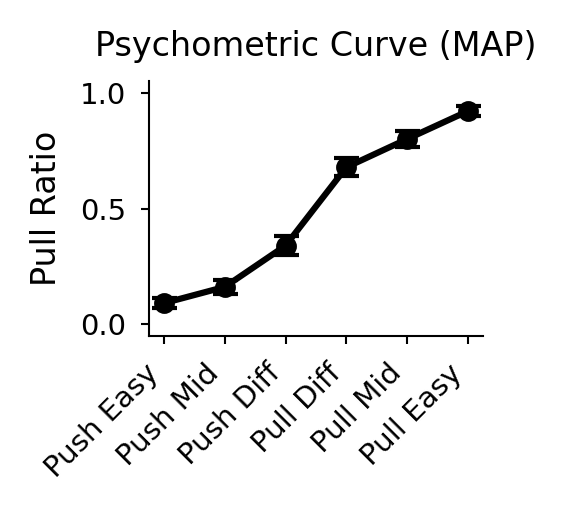

In [19]:

states = [0, 1]
levels = [0, 1, 2]

results = {}
outcomes_by_level = defaultdict(list)

for state in states:
    for level in levels:
        subset_df = results_df[
            (results_df['xt'].apply(lambda x: x[0]) == state) &
            (results_df['level'] == level)
        ]
        if subset_df.empty:
            results[(state, level)] = (np.nan, np.nan)
            continue

        trial_outcomes = []

        for index, row in subset_df.iterrows():
            post = row['post']
            true_state = row['xt'][0]
            mapestimate = row['mapestimate']

            choice = np.argmax(mapestimate[-1])

            trial_outcomes.append(1 if choice == true_state else 0)

        outcomes_by_level[level].extend(trial_outcomes)

        if len(trial_outcomes) > 0:
            mean_accuracy = np.mean(trial_outcomes)
            std_accuracy = np.std(trial_outcomes, ddof=0) if len(trial_outcomes) > 1 else 0
            CI_low_accuracy, CI_high_accuracy = proportion_confint(sum(trial_outcomes), len(trial_outcomes), alpha=0.05, method='wilson')
            CI_accuracy = CI_high_accuracy - mean_accuracy
        else:
            mean_accuracy, std_accuracy, CI_accuracy = np.nan, np.nan, np.nan
        results[(state, level)] = (mean_accuracy, std_accuracy, CI_accuracy)

print("\n--- Success rate by difficulty (Push/Pull, MAP estimate) ---")
level_names = {0: 'Easy', 1: 'Mid', 2: 'Diff'}
for level, outcomes in sorted(outcomes_by_level.items()):
    if outcomes:
        success_rate = np.mean(outcomes)
        num_trials = len(outcomes)
        print(f"Difficulty {level} ({level_names[level]}): {success_rate:.2%} (Trial num: {num_trials})")
print("--------------------------------------------------\n")

mean_accuracies = np.array([results.get((s, l), (np.nan, np.nan))[0] for s in states for l in levels])
std_accuracies = np.array([results.get((s, l), (np.nan, np.nan))[1] for s in states for l in levels])
CI_accuracies = np.array([results.get((s, l), (np.nan, np.nan))[2] for s in states for l in levels])
categories = ['Push Easy', 'Push Mid', 'Push Diff', 'Pull Easy', 'Pull Mid', 'Pull Diff']
order = [0, 1, 2, 5, 4, 3]
categories_ordered = [categories[i] for i in order]
mean_choice1_fraction = np.array([
    1 - mean_accuracies[0], 1 - mean_accuracies[1], 1 - mean_accuracies[2],
    mean_accuracies[3],     mean_accuracies[4],     mean_accuracies[5]
])
std_choice1_fraction = std_accuracies
CI_choice1_fraction = CI_accuracies
mean_choice1_fraction_ordered = mean_choice1_fraction[order]
std_choice1_fraction_ordered = std_choice1_fraction[order]
CI_choice1_fraction_ordered = CI_choice1_fraction[order]
simulation_data_df = pd.DataFrame({
    'Category': categories_ordered,
    'Mean': mean_choice1_fraction_ordered,
    'STD': std_choice1_fraction_ordered,
    'CI': CI_choice1_fraction_ordered
})
file_path_sim = 'simulation_psychometric_data_MAP_CI.csv'
simulation_data_df.to_csv(file_path_sim, index=False, encoding='utf-8-sig')

fig, ax = plt.subplots(figsize=(1.75, 1.75), dpi=300)
x = np.arange(6)
ax.errorbar(x, mean_choice1_fraction_ordered, yerr=CI_choice1_fraction_ordered, color='black', linewidth=1.5, marker='o', markersize=4, capsize=3)

ax.set_ylabel('Pull Ratio', fontsize=8)
ax.set_title('Psychometric Curve (MAP)', fontsize=8)
ax.set_xticks(x)
ax.set_xticklabels(categories_ordered, rotation=45, ha='right')
ax.set_ylim(-0.05, 1.05)
ax.tick_params(axis='both', which='major', labelsize=7)
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig("psychometric_curve_MAP_CI.svg", format="svg", bbox_inches='tight')
plt.show()
plt.close()

In [20]:
opto_conditions = [None, "L2IT", "L5IT"]
all_plot_data = []

all_trials_for_stats = []
for opto in opto_conditions:
    condition_name = "Control" if opto is None else opto
    print(f"--- Running Simulation for Condition: {condition_name} ---")

    results_list = []
    levels = [0, 1, 2]

    for level in levels:
        if level == 0:
            po = 0.13
        elif level == 1:
            po = 0.12
        elif level == 2:
            po = 0.11

        Pobs = np.zeros((no, ns))
        Pobs[0, 0] = Pobs[2, 1] = po
        Pobs[2, 0] = Pobs[0, 1] = 0.2 - po
        Pobs[1, 0] = Pobs[1, 1] = 0.8
        ring = HMM(Ptr, Pobs)

        for iteration in range(num_repeats):
            # Simulate observation sequence and underlying states
            start_times, durations, xt, yt = ring.simulate_observations(T)

            # Initialize inference variables
            post = np.zeros((T, ns))
            observation = np.zeros((T, no))
            likelihood = np.zeros((T, ns))
            nll = np.zeros((T, ns))
            prediction = np.zeros((ns, ns))
            predictiveprior = np.zeros((T, ns))
            mapestimate = np.zeros((T, ns))

            ring.reset()

            # Perform dynamic Bayesian inference based on opto condition
            if opto == "L2IT":
                for t in range(T):
                    if t < T // 2:
                        post[t], observation[t], likelihood[t], prediction, predictiveprior[t], mapestimate[t], nll[t] = ring.step(yt[t])
                    else:
                        post[t], observation[t], likelihood[t], prediction, predictiveprior[t], mapestimate[t], nll[t] = ring.step_L2(yt[t])
            elif opto == "L5IT":
                for t in range(T):
                    if t < T // 2:
                        post[t], observation[t], likelihood[t], prediction, predictiveprior[t], mapestimate[t], nll[t] = ring.step(yt[t])
                    else:
                        post[t], observation[t], likelihood[t], prediction, predictiveprior[t], mapestimate[t], nll[t] = ring.step_L5(yt[t])
            else: # opto is None
                for t in range(T):
                    post[t], observation[t], likelihood[t], prediction, predictiveprior[t], mapestimate[t], nll[t] = ring.step(yt[t])

            current_result = {
                'level': level,
                'iteration': iteration,
                'xt': xt,
                'yt': yt,
                'post': post,
                'mapestimate':mapestimate
            }
            results_list.append(current_result)

    results_df = pd.DataFrame(results_list)

    states = [0, 1] # 0: Push, 1: Pull
    levels = [0, 1, 2] # 0: Easy, 1: Mid, 2: Diff
    results = {}
    outcomes_by_level = defaultdict(list)

    category_map = {
        (0, 0): 'Push Easy', (0, 1): 'Push Mid', (0, 2): 'Push Diff',
        (1, 0): 'Pull Easy', (1, 1): 'Pull Mid', (1, 2): 'Pull Diff'
    }

    for state in states:
        for level in levels:
            subset_df = results_df[
                (results_df['xt'].apply(lambda x: x[0]) == state) &
                (results_df['level'] == level)
            ]
            if subset_df.empty:
                results[(state, level)] = (np.nan, np.nan)
                continue

            trial_outcomes = []
            for index, row in subset_df.iterrows():
                choice = np.argmax(row['mapestimate'][-1])
                trial_outcomes.append(1 if choice == row['xt'][0] else 0)
                current_category = category_map[(state, level)]
                all_trials_for_stats.append({
                    'Condition': condition_name,
                    'Category': current_category,
                    'Pull_Choice': choice  # 0: Push, 1: Pull
                })
            outcomes_by_level[level].extend(trial_outcomes)

            if trial_outcomes:
                mean_accuracy = np.mean(trial_outcomes)
                std_accuracy = np.std(trial_outcomes, ddof=0)
            else:
                mean_accuracy, std_accuracy = np.nan, np.nan
            results[(state, level)] = (mean_accuracy, std_accuracy)

    print(f"\n--- Success Rate (MAP) for {condition_name} ---")
    level_names = {0: 'Easy', 1: 'Mid', 2: 'Diff'}
    for level, outcomes in sorted(outcomes_by_level.items()):
        if outcomes:
            success_rate = np.mean(outcomes)
            num_trials = len(outcomes)
            print(f"Level {level} ({level_names[level]}): {success_rate:.2%} (n={num_trials})")
    print("--------------------------------------------------\n")

    mean_accuracies = np.array([results.get((s, l), (np.nan, np.nan))[0] for s in states for l in levels])
    std_accuracies = np.array([results.get((s, l), (np.nan, np.nan))[1] for s in states for l in levels])

    categories = ['Push Easy', 'Push Mid', 'Push Diff', 'Pull Easy', 'Pull Mid', 'Pull Diff']
    order = [0, 1, 2, 5, 4, 3]
    categories_ordered = [categories[i] for i in order]

    mean_choice_pull_fraction = np.array([
        1 - mean_accuracies[0], 1 - mean_accuracies[1], 1 - mean_accuracies[2],
        mean_accuracies[3], mean_accuracies[4], mean_accuracies[5]
    ])

    mean_choice_pull_fraction_ordered = mean_choice_pull_fraction[order]
    std_choice_pull_fraction_ordered = std_accuracies[order]

    simulation_data_df = pd.DataFrame({
        'Category': categories_ordered,
        'Mean': mean_choice_pull_fraction_ordered,
        'STD': std_choice_pull_fraction_ordered
    })

    simulation_data_df['Condition'] = condition_name
    all_plot_data.append(simulation_data_df)

--- Running Simulation for Condition: Control ---

--- Success Rate (MAP) for Control ---
Level 0 (Easy): 90.90% (n=1000)
Level 1 (Mid): 81.00% (n=1000)
Level 2 (Diff): 67.30% (n=1000)
--------------------------------------------------

--- Running Simulation for Condition: L2IT ---

--- Success Rate (MAP) for L2IT ---
Level 0 (Easy): 81.20% (n=1000)
Level 1 (Mid): 73.70% (n=1000)
Level 2 (Diff): 63.30% (n=1000)
--------------------------------------------------

--- Running Simulation for Condition: L5IT ---

--- Success Rate (MAP) for L5IT ---
Level 0 (Easy): 52.50% (n=1000)
Level 1 (Mid): 51.90% (n=1000)
Level 2 (Diff): 48.50% (n=1000)
--------------------------------------------------




     STATISTICAL ANALYSIS (Chi-squared test)     

--- Analyzing Category: Push Easy ---
Overall Chi-squared test: p-value = 0.0000
Significant difference found. Performing post-hoc tests...
Post-hoc results (Bonferroni-corrected p-values):
  Control vs L2IT: p = 0.0001
  Control vs L5IT: p = 0.0000
  L2IT vs L5IT: p = 0.0000

--- Analyzing Category: Push Mid ---
Overall Chi-squared test: p-value = 0.0000
Significant difference found. Performing post-hoc tests...
Post-hoc results (Bonferroni-corrected p-values):
  Control vs L2IT: p = 0.0025
  Control vs L5IT: p = 0.0000
  L2IT vs L5IT: p = 0.0000

--- Analyzing Category: Push Diff ---
Overall Chi-squared test: p-value = 0.0000
Significant difference found. Performing post-hoc tests...
Post-hoc results (Bonferroni-corrected p-values):
  Control vs L2IT: p = 0.8601
  Control vs L5IT: p = 0.0000
  L2IT vs L5IT: p = 0.0000

--- Analyzing Category: Pull Diff ---
Overall Chi-squared test: p-value = 0.0000
Significant difference found. Perf

/tmp/ipython-input-2021849637.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_df = stats_df.groupby(['Condition', 'Category'])['Pull_Choice'].agg(['sum', 'count']).reset_index()
/tmp/ipython-input-2021849637.py:103: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (condition_name, group_df) in enumerate(final_plot_df.groupby('Condition')):


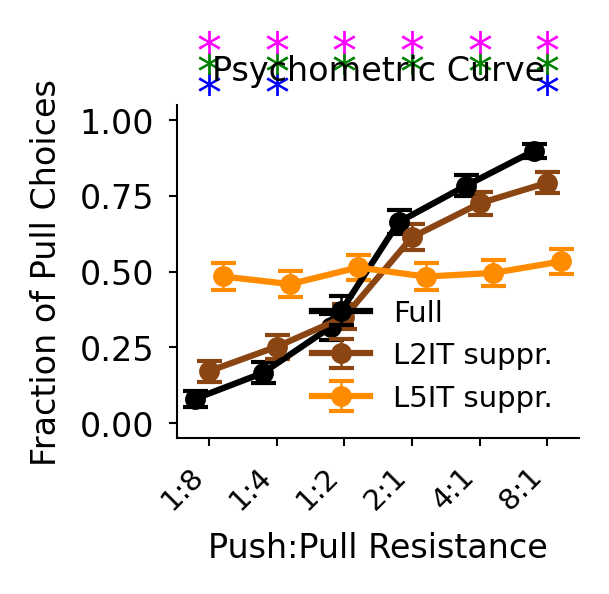

In [21]:
# --- 2. Chi-squared Test and Manual Post-hoc Tests ---
test_results = []
print("\n" + "="*50)
print("     STATISTICAL ANALYSIS (Chi-squared test)     ")
print("="*50 + "\n")
stats_df = pd.DataFrame(all_trials_for_stats)
categories = ['Push Easy', 'Push Mid', 'Push Diff', 'Pull Easy', 'Pull Mid', 'Pull Diff']
xticklabels = ['1:8','1:4','1:2','2:1','4:1','8:1']
order = [0, 1, 2, 5, 4, 3]; categories_ordered = [categories[i] for i in order]
stats_df['Category'] = pd.Categorical(stats_df['Category'], categories=categories_ordered, ordered=True)
conditions_to_test = [c for c in ["Control", "L2IT", "L5IT"] if c in stats_df['Condition'].unique()]
condition_pairs = list(combinations(conditions_to_test, 2))
num_tests = len(condition_pairs) * len(categories_ordered)
# Loop through each category
for category in categories_ordered:
    print(f"--- Analyzing Category: {category} ---")

    # Extract data for the current category
    category_df = stats_df[stats_df['Category'] == category]

    # 1. Create a contingency table (counts of success(1)/failure(0) per condition)
    contingency_table = pd.crosstab(category_df['Condition'], category_df['Pull_Choice'])

    # Skip if there are fewer than 2 conditions to compare
    if contingency_table.shape[0] < 2:
        print("Skipping: Not enough conditions to compare.\n")
        continue

    # 2. Perform the overall Chi-squared test
    chi2, p_val, _, _ = chi2_contingency(contingency_table)
    print(f"Overall Chi-squared test: p-value = {p_val:.4f}")

    # 3. If the overall test is significant, perform post-hoc tests
    if p_val < 0.05:
        print("Significant difference found. Performing post-hoc tests...")

        # Get all unique pairs of conditions for pairwise comparison
        condition_pairs = list(combinations(contingency_table.index, 2))
        uncorrected_p_values = []

        # Perform pairwise chi-squared test for each pair
        for pair in condition_pairs:
            pair_table = contingency_table.loc[list(pair)]
            _, p_uncorrected, _, _ = chi2_contingency(pair_table)
            uncorrected_p_values.append(p_uncorrected)

        # 4. Apply Bonferroni correction for multiple comparisons
        reject, p_corrected, _, _ = multipletests(uncorrected_p_values, alpha=0.05, method='bonferroni')

        print("Post-hoc results (Bonferroni-corrected p-values):")
        # 5. Store significant results for plotting
        for i, pair in enumerate(condition_pairs):
            print(f"  {pair[0]} vs {pair[1]}: p = {p_corrected[i]:.4f}")
            if p_corrected[i] < 0.05:
                # Sort pair alphabetically for consistent comparison string
                sorted_pair = sorted(pair)
                comparison_str = f"{sorted_pair[0]}_vs_{sorted_pair[1]}"
                test_results.append({
                    'Category': category,
                    'Comparison': comparison_str,
                    'P-value (Bonferroni)': p_corrected[i],
                    'Significant (p < 0.05)': True
                })
        print() # Add a newline for readability
    else:
        print("No significant overall difference.\n")

results_table = pd.DataFrame(test_results)
if not results_table.empty:
    print("\n" + "="*50)
    print("      SUMMARY OF SIGNIFICANT POST-HOC RESULTS      ")
    print("="*50 + "\n")
    print(results_table.round(4))

# --- 3. Create DataFrame for Plotting (using 95% Confidence Intervals) ---
# Aggregate successes (sum) and total trials (count)
summary_df = stats_df.groupby(['Condition', 'Category'])['Pull_Choice'].agg(['sum', 'count']).reset_index()
summary_df.rename(columns={'sum': 'successes', 'count': 'nobs'}, inplace=True)

# Calculate Wilson score confidence intervals
summary_df['conf_low'], summary_df['conf_high'] = proportion_confint(
    count=summary_df['successes'],
    nobs=summary_df['nobs'],
    alpha=0.05, # for a 95% CI
    method='wilson'
)

# Calculate mean and error margin for the plot
summary_df['Mean'] = summary_df['successes'] / summary_df['nobs']
summary_df['Error'] = summary_df['conf_high'] - summary_df['Mean']

final_plot_df = summary_df
final_plot_df['Condition'] = pd.Categorical(final_plot_df['Condition'], categories=["Control", "L2IT", "L5IT"], ordered=True)
final_plot_df.sort_values('Condition', inplace=True)

# --- 4. Plotting Results and Significance Stars ---
fig, ax = plt.subplots(figsize=(2.0, 2.1), dpi=300)
x = np.arange(len(categories_ordered))
colors = {'Control': 'black', 'L2IT': 'saddlebrown', 'L5IT': 'darkorange'}
labels = {'Control': 'Full', 'L2IT': 'L2IT suppr.', 'L5IT': 'L5IT suppr.'}
num_conditions = len(final_plot_df['Condition'].unique()); dodge_width = 0.4

for i, (condition_name, group_df) in enumerate(final_plot_df.groupby('Condition')):
    group_df['Category'] = pd.Categorical(group_df['Category'], categories=categories_ordered, ordered=True)
    group_df = group_df.sort_values('Category')
    offset = dodge_width * (i / (num_conditions - 1) - 0.5) if num_conditions > 1 else 0
    # Use the calculated 'Error'
    ax.errorbar(x + offset, group_df['Mean'], yerr=group_df['Error'], fmt='-o', color=colors.get(condition_name, 'gray'),
                linewidth=1.5, markersize=4, capsize=3, elinewidth=0.6, alpha=1.0, label=labels.get(condition_name))

# Draw significance stars (no changes needed here)
if not results_table.empty:
    y_base = 1.08; y_increment = 0.07 # Adjust y-position for stars
    star_counts = {cat: 0 for cat in categories_ordered}
    category_to_x = {cat: i for i, cat in enumerate(categories_ordered)}

    # Ensure comparison strings are sorted alphabetically to match results_table
    comparison_styles = {
        'Control_vs_L2IT': {'color': 'blue', 'marker': '*'},
        'Control_vs_L5IT': {'color': 'green', 'marker': '*'},
        'L2IT_vs_L5IT': {'color': 'magenta', 'marker': '*'}
    }

    for _, row in results_table.iterrows():
        category, comparison = row['Category'], row['Comparison']
        x_pos = category_to_x[category]

        y_pos = y_base
        if comparison == 'Control_vs_L5IT': y_pos += y_increment
        if comparison == 'L2IT_vs_L5IT': y_pos += y_increment * 2

        style = comparison_styles.get(comparison, {'color': 'black', 'marker': '*'})
        ax.text(x_pos, y_pos, style['marker'], color=style['color'], fontsize=12, ha='center', va='center')

ax.set_xlabel('Push:Pull Resistance', fontsize=8)
ax.set_ylabel('Fraction of Pull Choices', fontsize=8)
ax.set_title('Psychometric Curve', fontsize=8)
ax.set_xticks(x); ax.set_xticklabels(xticklabels, rotation=45, ha='right', fontsize=7)
ax.set_ylim(-0.05, 1.05)

ax.legend(frameon=False, fontsize=7)

ax.grid(False); ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig("psychometric_curve_HMM_with_stats_chisq_manual.svg", format="svg", bbox_inches='tight')
plt.show()
plt.close()